Loading two camera views and camera's intrinsic matrix $K$

<IPython.core.display.Javascript object>


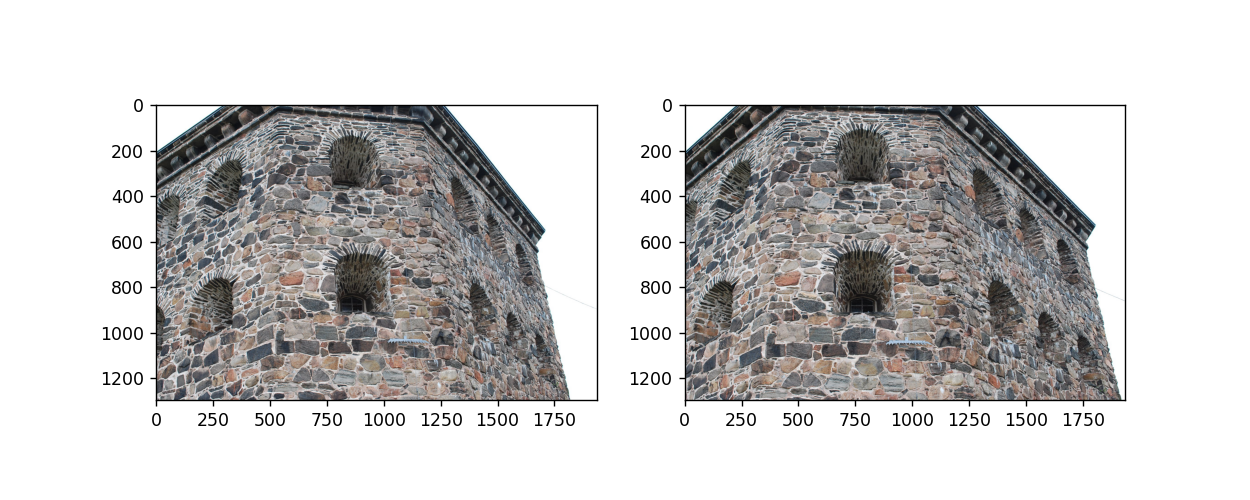

In [1]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform, EssentialMatrixTransform, FundamentalMatrixTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

# Indicate (E) inlier matches in image 1 and image 2
# loading two images (two camera views) and the corresponding matrix K (intrinsic parameters)
imL = image.imread("images/kronan1.jpg")
imR = image.imread("images/kronan2.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

K = 1.0e+03 * np.array([[2.3940, -0.0000,    0.9324],
                        [     0,  2.3981,    0.6283],
                        [     0,       0,    0.0010]])


plt.figure(0,figsize = (10, 4))
ax81 = plt.subplot(121)
plt.imshow(imL)
ax82 = plt.subplot(122)
plt.imshow(imR)
plt.show()

Feature detection (corners)

the number of features in images 1 and 2 are  1576 and  1661


<IPython.core.display.Javascript object>


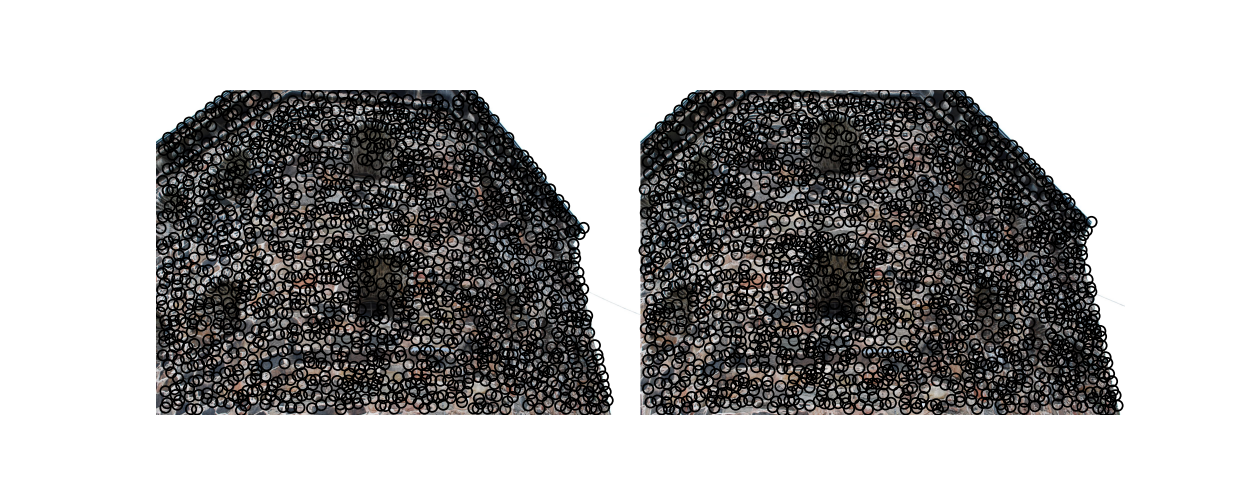

In [2]:
# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.001, min_distance=15)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.001, min_distance=15)


print ('the number of features in images 1 and 2 are {:5d} and {:5d}'.format(keypointsL.shape[0],keypointsR.shape[0]))

fig = plt.figure(1,figsize = (10, 4))
axA = plt.subplot(111)
plt.gray()
matchesLR = np.empty((0,2))
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR)
axA.axis('off')

plt.show()

Feature matching

the number of matches is 964


<IPython.core.display.Javascript object>


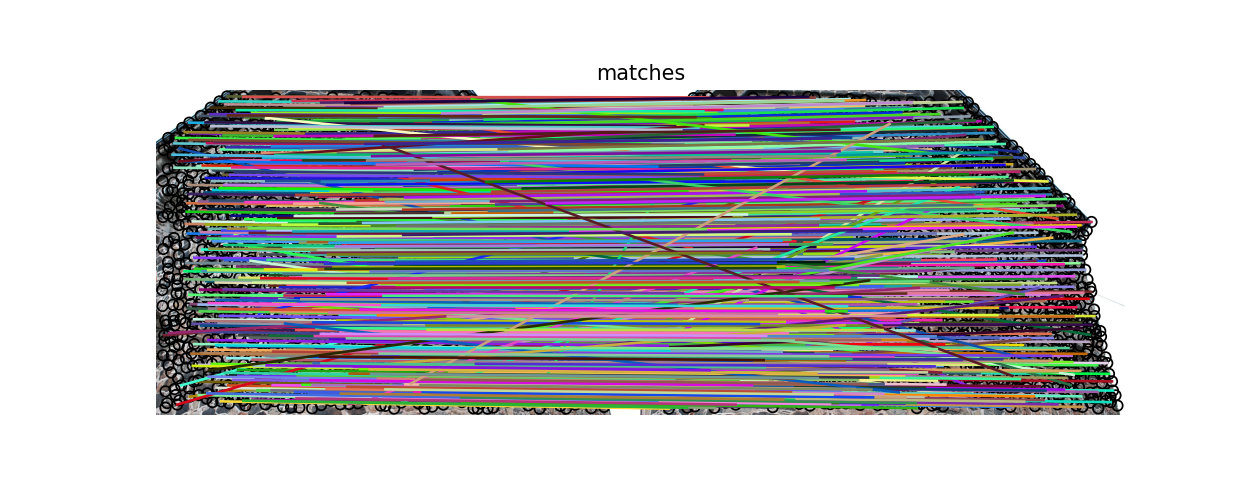

In [3]:
extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(2,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("matches")
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

Fundamental Matrix estimation using RANSAC

the number of inliers is 189


<IPython.core.display.Javascript object>


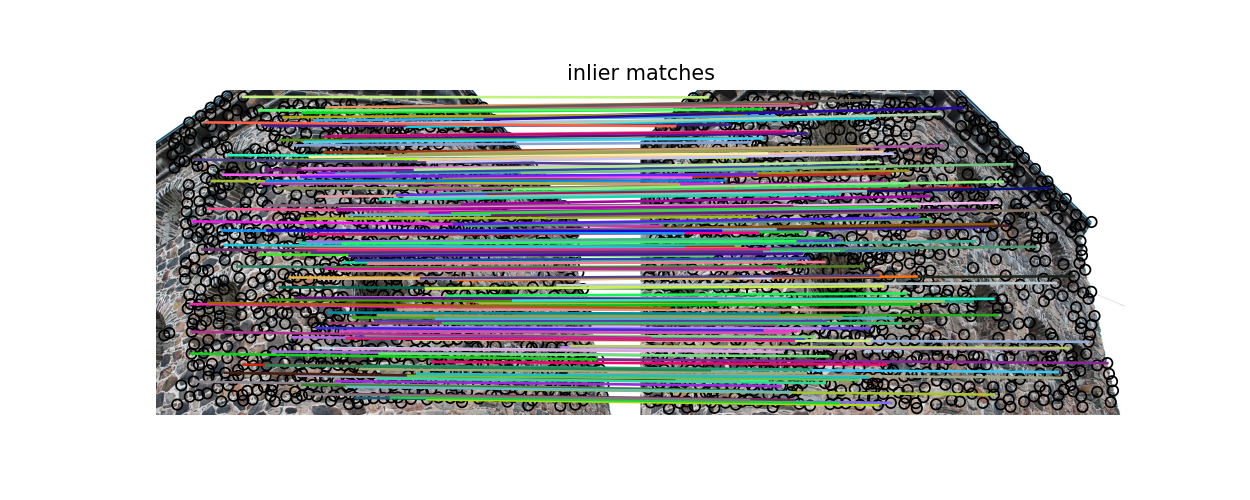

In [4]:
ptsL1 = []
ptsR1 = []
for i in matchesLR:
    ptsL1.append(keypointsL[i[0]])
    ptsR1.append(keypointsR[i[1]])
ptsL1 = np.array(ptsL1)
ptsR1 = np.array(ptsR1)

# swapping columns using advanced indexing https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing
# This changes point coordinates from (y,x) in ptsL1/ptsR1 to (x,y) in ptsL/ptsR
ptsL = ptsL1[:,[1, 0]]
ptsR = ptsR1[:,[1, 0]]

# robustly estimate fundamental matrix using RANSAC
F_trans, F_inliers = ransac((ptsL, ptsR), FundamentalMatrixTransform, min_samples=8, residual_threshold=0.1, max_trials=1500)
print ('the number of inliers is {:2d}'.format(np.sum(F_inliers)))

ind = np.ogrid[:ptsL.shape[0]]
FmatchesRansac = np.column_stack((ind[F_inliers],ind[F_inliers]))

fig = plt.figure(3,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, FmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

Singular values for F

In [5]:
F = F_trans.params
Uf,Sf,Vf = la.svd(F, full_matrices=False)
print (Sf)

[8.01230136e-02 6.11523192e-05 1.01190509e-20]


Epipolar lines from F

<IPython.core.display.Javascript object>


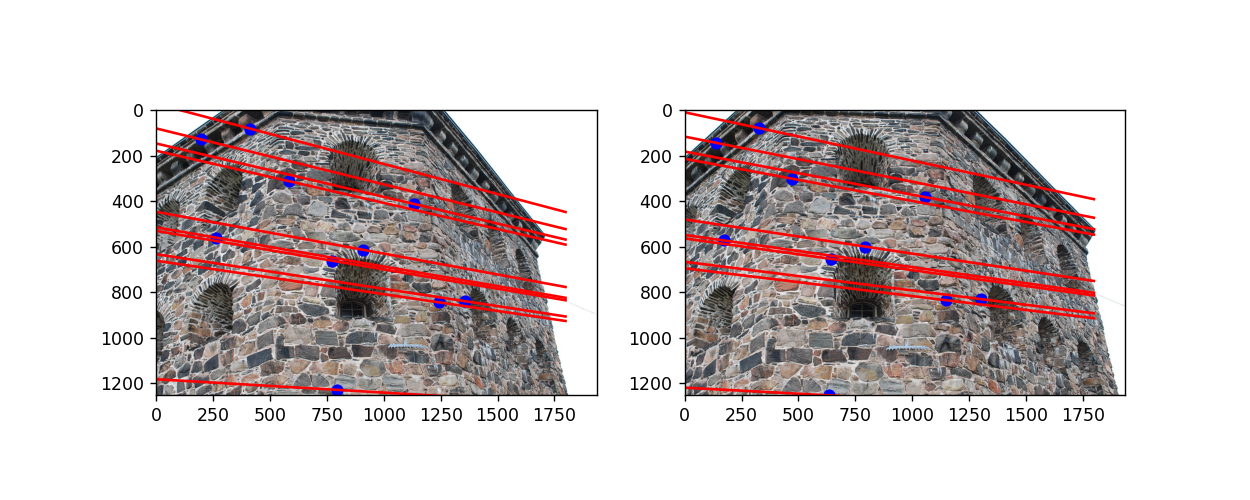

In [6]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for F
ind_sample = np.random.choice(ind[F_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(4,figsize = (10, 4))
ax41 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax42 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homogeneous 3-vectors l2 representing lines l2 x  = 0) 
# create an array of points sampled in images 1 and 2
sample_points_L = np.array(ptsL[ind_sample])
sample_points_R = np.array(ptsR[ind_sample])

# create an array of homogeneous points sampled in images 1 and 2
ones = np.ones((10,1), dtype=int)
hom_points_L = np.hstack((sample_points_L, ones))
hom_points_R = np.hstack((sample_points_R, ones))

# create an array of the corresponding epipolar lines in images 1 and 2
lines_L = np.array([np.transpose(np.matrix(F)) * np.reshape(p, (3,1)) for p in hom_points_R])
lines_R = np.array([np.matrix(F) * np.reshape(p, (3,1)) for p in hom_points_L])

# for each feature (in both images) draw a correspoindiung epipolar line in the other image

x = np.arange(0, 1800)

#line is l0 x + l1 y + l2 = 0 so: y = -l0/l1 x - l2/l1 
for line in lines_L:
    ax41.plot(x, -x*line[0,0]/line[1,0] - line[2,0]/line[1,0] , '-r')
ax41.set_ylim([1250,0])  

for line in lines_R:
    ax42.plot(x, -x*line[0,0]/line[1,0] - line[2,0]/line[1,0] , '-r')
ax42.set_ylim([1250,0])


plt.show()

Camera Normalization and Essential Matrix estimation using RANSAC

the number of inliers is 839


<IPython.core.display.Javascript object>


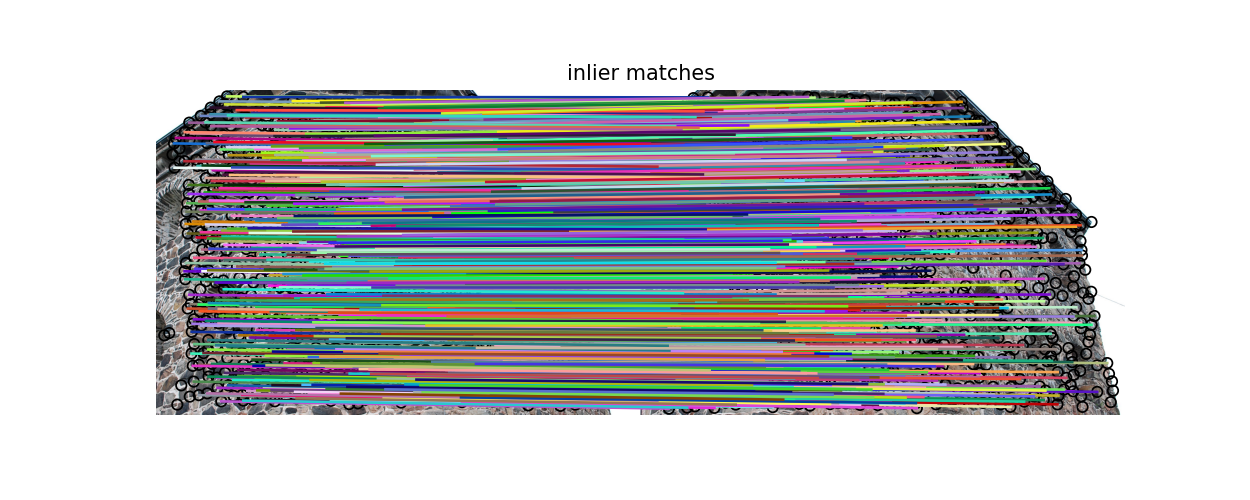

In [7]:
# normalization of points in two images using K (intrinsic parameters) e.g. in the following three steps
# convert original points to homogeneous 3-vectors (append "1" as a 3rd coordinate using np.append function)
h_ptsL = np.hstack((ptsL, np.ones((ptsL.shape[0],1), dtype=int)))
h_ptsR = np.hstack((ptsR, np.ones((ptsR.shape[0],1), dtype=int)))

# transform the point by applying the inverse of K
nh_ptsL = np.array([la.inv(np.matrix(K)) * np.reshape(p, (3,1)) for p in h_ptsL])
nh_ptsR = np.array([la.inv(np.matrix(K)) * np.reshape(p, (3,1)) for p in h_ptsR])

# convert homogeneous 3-vectors to 2-vectors (in R2)
n_ptsL = np.squeeze(np.array([(p[0]/p[2], p[1]/p[2]) for p in nh_ptsL]))
n_ptsR = np.squeeze(np.array([(p[0]/p[2], p[1]/p[2]) for p in nh_ptsR]))

# robustly estimate essential matrix using normalized points and RANSAC
E_trans, E_inliers = ransac((n_ptsL, n_ptsR), EssentialMatrixTransform, min_samples=8, residual_threshold=0.0005, max_trials=5000)
num_inliers = np.sum(E_inliers)
print ('the number of inliers is {:2d}'.format(num_inliers))

ind = np.ogrid[:n_ptsL.shape[0]]
EmatchesRansac = np.column_stack((ind[E_inliers],ind[E_inliers]))

fig = plt.figure(5,figsize = (10, 4))
axA = plt.subplot(111)
axA.set_title("inlier matches")
plt.gray()
# NOTE: function "plot matches" expects that keypoint coordinates are given as (y,x), that is (row, col)
plot_matches(axA, imL, imR, ptsL1, ptsR1, EmatchesRansac) #, matches_color = 'r')
axA.axis('off')
plt.show()

### singular values for E
#### Hint: function $svd$ from $linalg$ returns transpose $V^T$, not $V$.  

In [8]:
E = E_trans.params
Ue,Se,Ve = la.svd(E)

### Step 6: Epipolar Lines from E 

<IPython.core.display.Javascript object>


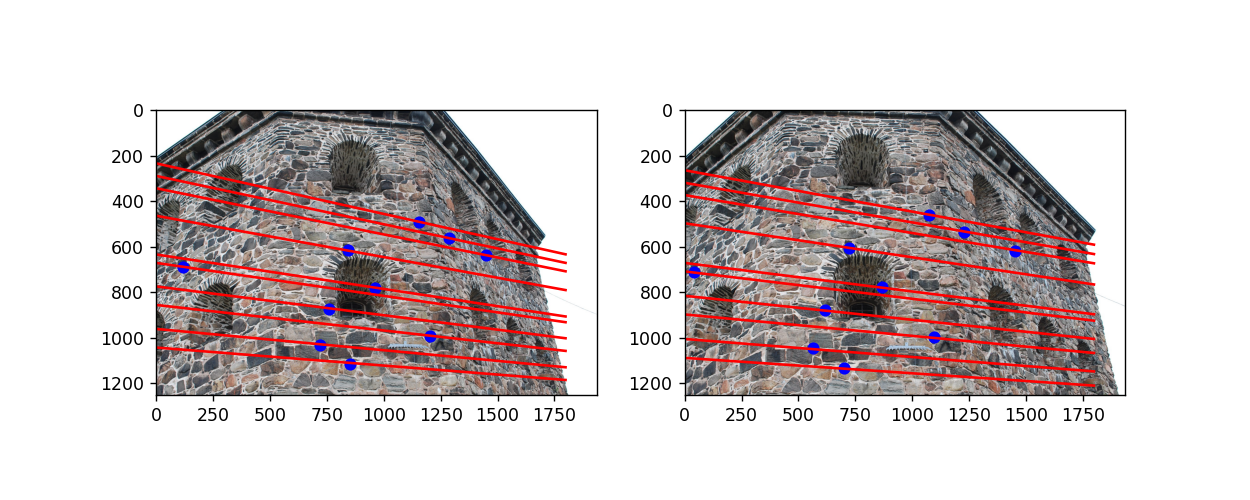

In [9]:
# Randomly select 10 matches (paris of features in two images) from the set of inliers for E
ind_sample = np.random.choice(ind[E_inliers], 10, replace = False)

# Indicate these matching features in image 1 and image 2
plt.figure(6,figsize = (10, 4))
ax61 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind_sample, 0], ptsL[ind_sample, 1], 'ob')
ax62 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind_sample, 0], ptsR[ind_sample, 1], 'ob')

# generate epipolar line equations in image 2 (homoheneous 3-vectors l2 representing lines l2 x  = 0) 
# create an array of normalized points sampled in image 1
sample_pts_L = np.array(n_ptsL[ind_sample])
sample_pts_R = np.array(n_ptsR[ind_sample])

# create an array of homogeneous normalized points sampled in image 1
hom_pts_L = np.array(nh_ptsL[ind_sample])
hom_pts_R = np.array(nh_ptsR[ind_sample])

# create an array of the corresponding (uncalibrated) epipolar lines in image 2
K_inv = la.pinv(K)
lines_L = np.array([np.matmul(np.resize(p, (1,3)), np.matmul(E, K_inv)) for p in hom_pts_R])
lines_R = np.array([np.matmul(np.resize(p, (1,3)), np.matmul(np.transpose(E), K_inv)) for p in hom_pts_L])

lines_L = [l.reshape(3,) for l in lines_L]
lines_R = [l.reshape(3,) for l in lines_R]

# for each feature (in both images) draw a correspoindiung epipolar line in the other image

x = np.arange(0, 1800)    
# line is l0 x + l1 y + l2 = 0 so: y = -l0/l1 x - l2/l1
for line in lines_L:
    ax61.plot(x, -x*line[0]/line[1] - line[2]/line[1] , '-r')
ax61.set_ylim([1250,0])  

for line in lines_R:
    ax62.plot(x, -x*line[0]/line[1] - line[2]/line[1] , '-r')
ax62.set_ylim([1250,0])  

plt.show()

Camera rotation and translation (four solutions)

In [10]:
if la.det(np.matmul(Ue,Ve)) < 0:
    # switch sign of last col of V (last row of Ve=V^T)
    Ve = np.matmul(np.diag([1,1,-1]),Ve)

W = np.matrix([[0,-1,0],[1,0,0],[0,0,1]])

R1 = np.matmul(np.matmul(Ue, W), Ve)
R2 = np.matmul(np.matmul(Ue, np.transpose(W)), Ve)
R1 = Ue @ W @ Ve
R2 = Ue @ np.transpose(W) @ Ve
T1 = np.reshape(Ue[:,-1], (3,1))
T2 = np.reshape(-1 * Ue[:,-1], (3,1))

# first camera matrix
Pw = np.append(np.identity(3), np.zeros((3,1)), axis=1)

# four possible matrices for the second camera
Pa = np.append(R1, T1, axis=1)
Pb = np.append(R1, T2, axis=1)
Pc = np.append(R2, T1, axis=1)
Pd = np.append(R2, T2, axis=1)

Triangulation

In [11]:
# Select normalized coordinates for matched features that are inliers for essential matrix E. 
# Form matrix A in equation AX=0 where X represent 4 vectors (homogeneous representation of 3D point).
# Each camera (projection matrix P) will define its own A

def get_A(P, pL, pR):
    u1, v1 = pL
    u2, v2 = pR
    a,b,c,d,e,f,g,h,i,j,k,l = np.reshape(P, (12,))[0].tolist()[0]
    A = np.matrix([[1, 0, -u1, 0],
        [0, 1, -v1, 0],
        [a-i*u2, b-j*u2, c-k*u2, d-l*u2],
        [e-i*v2, f-j*v2, g-k*v2, h-l*v2]])
    return A

inliers_L = n_ptsL[ind[E_inliers]]
inliers_R = n_ptsR[ind[E_inliers]]

Aa = np.array([get_A(Pa, pL, pR) for pL, pR in zip(inliers_L, inliers_R)])
Ab = np.array([get_A(Pb, pL, pR) for pL, pR in zip(inliers_L, inliers_R)])
Ac = np.array([get_A(Pc, pL, pR) for pL, pR in zip(inliers_L, inliers_R)])
Ad = np.array([get_A(Pd, pL, pR) for pL, pR in zip(inliers_L, inliers_R)])

Find solution using least squares

In [12]:
# least squares for solving linear system A_{0:2} X_{0:2} = - A_3 
Aa_02 = np.array([A[:,0:3] for A in Aa])       # the first 3 columns of 4x4 matrix A
Aa_3  = np.array([A[:,-1] for A in Aa])        # the last column on 4x4 matrix A
Ab_02 = np.array([A[:,0:3] for A in Ab])  
Ab_3  = np.array([A[:,-1] for A in Ab])     
Ac_02 = np.array([A[:,0:3] for A in Ac])   
Ac_3  = np.array([A[:,-1] for A in Ac])    
Ad_02 = np.array([A[:,0:3] for A in Ad])
Ad_3  = np.array([A[:,-1] for A in Ad])

def least_squares(A, B):
    X = np.matmul(la.pinv(A), B)
    return X
        
# Nx3 matrices: N rows with 3D point coordinates for N reconstructed points (N=num_inliers)
Xa = np.array([least_squares(A_02, -A_3) for A_02, A_3 in zip(Aa_02, Aa_3)])
Xb = np.array([least_squares(A_02, -A_3) for A_02, A_3 in zip(Ab_02, Ab_3)])
Xc = np.array([least_squares(A_02, -A_3) for A_02, A_3 in zip(Ac_02, Ac_3)])
Xd = np.array([least_squares(A_02, -A_3) for A_02, A_3 in zip(Ad_02, Ad_3)])

Camera positioning in 3D - compute location of each cameras' optical center and its (calibrated) image center as points in 3D

In [13]:
# camera's optical centers (for pair of cameras) as points in 3D world coordinate system
# 2x3 matrices: two rows with 3D point coordinates for the first and second camera

def get_opt_center(R, T):
    center_1 = np.zeros((1,3))
    T = np.reshape(T, (3,1))
    center_2 = np.reshape(np.matmul(-la.inv(R), T), (1,3))
    return np.squeeze(np.array([center_1, center_2]))

Ca = get_opt_center(R1, T1)
Cb = get_opt_center(R1, T2)
Cc = get_opt_center(R2, T1)
Cd = get_opt_center(R2, T2)

# calibrated/normalized image centers (for pair of cameras) as points in 3D world coordinate system

e3 = np.array([[0],[0],[1]])

def get_im_center(R, T):
    center_1 = np.reshape(e3, (1,3))
    center_2 = np.reshape(np.matmul(la.pinv(R), (e3 - T)), (1,3))
    return np.squeeze(np.array([center_1, center_2]))

Qa = get_im_center(R1, T1)
Qb = get_im_center(R1, T2)
Qc = get_im_center(R2, T1)
Qd = get_im_center(R2, T2)


 3D visualization of cameras and triangulated points (four solutions)

<IPython.core.display.Javascript object>


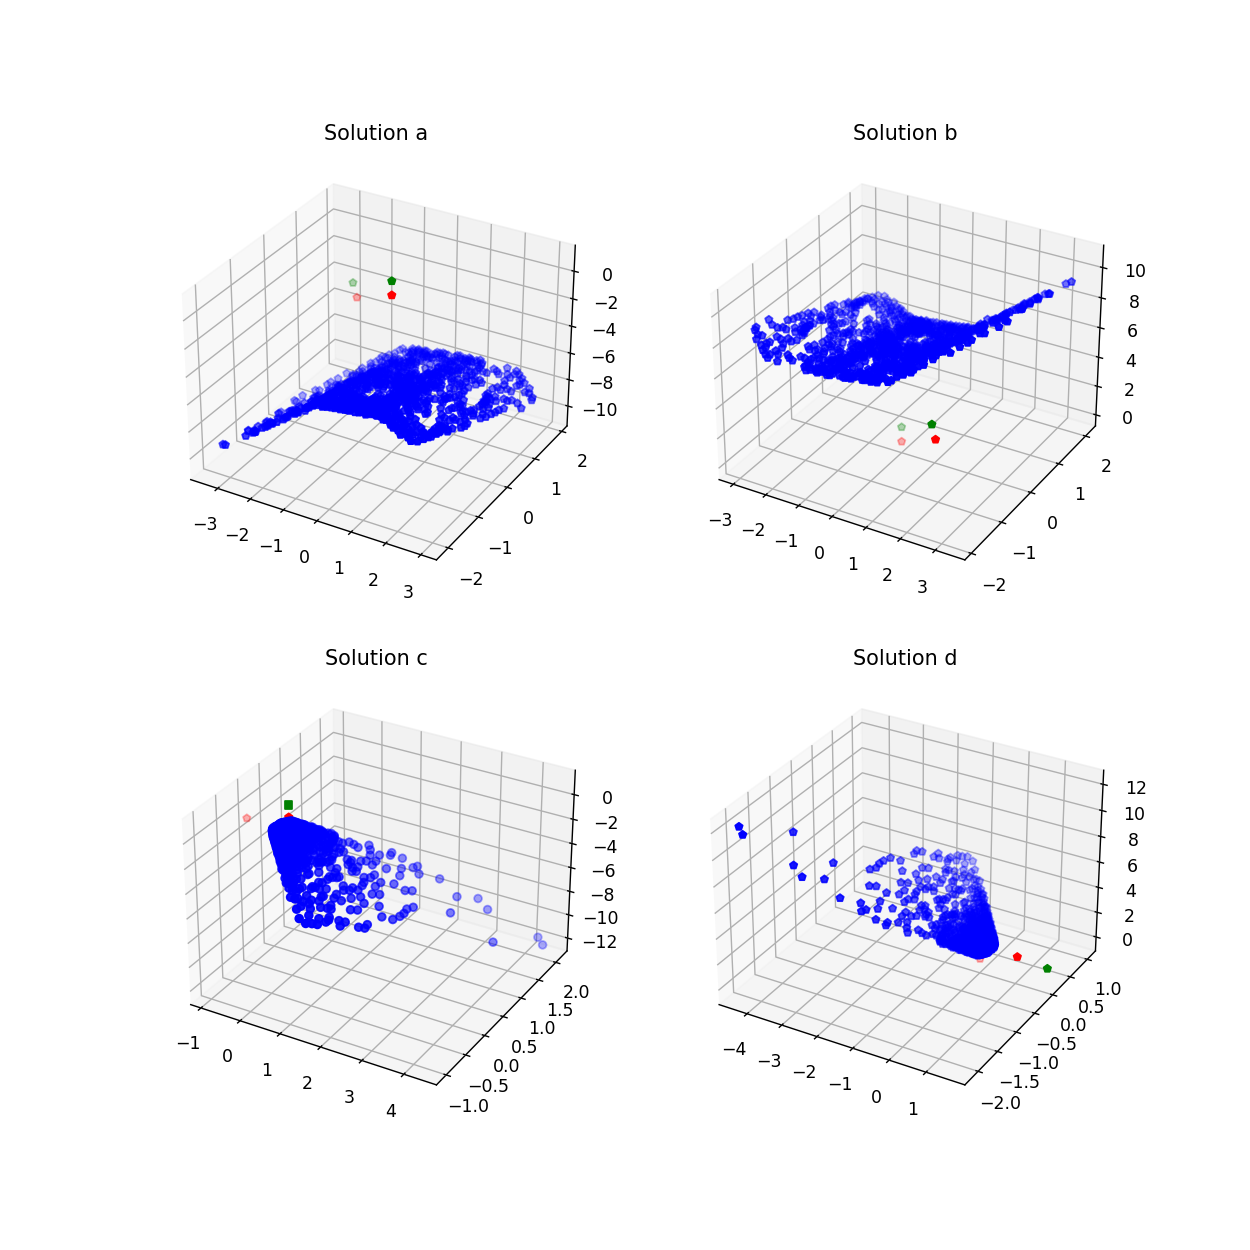

In [14]:
# visualization part
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(10,figsize = (10, 10))

ax10_1 = plt.subplot(221, projection='3d')
plt.title('Solution a')
ax10_1.scatter(Xa[:,0],Xa[:,1],Xa[:,2], c='b', marker='p')
ax10_1.scatter(Ca[:,0],Ca[:,1],Ca[:,2], c='r', marker='p')
ax10_1.scatter(Qa[:,0],Qa[:,1],Qa[:,2], c='g', marker='p')

ax10_2 = plt.subplot(222, projection='3d')
plt.title('Solution b')
ax10_2.scatter(Xb[:,0],Xb[:,1],Xb[:,2], c='b', marker='p')
ax10_2.scatter(Cb[:,0],Cb[:,1],Cb[:,2], c='r', marker='p')
ax10_2.scatter(Qb[:,0],Qb[:,1],Qb[:,2], c='g', marker='p')

ax10_3 = plt.subplot(223, projection='3d')
plt.title('Solution c')
ax10_3.scatter(Xc[:,0],Xc[:,1],Xc[:,2], c='b', marker='o')
ax10_3.scatter(Cc[:,0],Cc[:,1],Cc[:,2], c='r', marker='p')
ax10_3.scatter(Qc[:,0],Qc[:,1],Qc[:,2], c='g', marker='s')

ax10_4 = plt.subplot(224, projection='3d')
plt.title('Solution d')
ax10_4.scatter(Xd[:,0],Xd[:,1],Xd[:,2], c='b', marker='p')
ax10_4.scatter(Cd[:,0],Cd[:,1],Cd[:,2], c='r', marker='p')
ax10_4.scatter(Qd[:,0],Qd[:,1],Qd[:,2], c='g', marker='p')

plt.show()

Reprojection errors

<IPython.core.display.Javascript object>


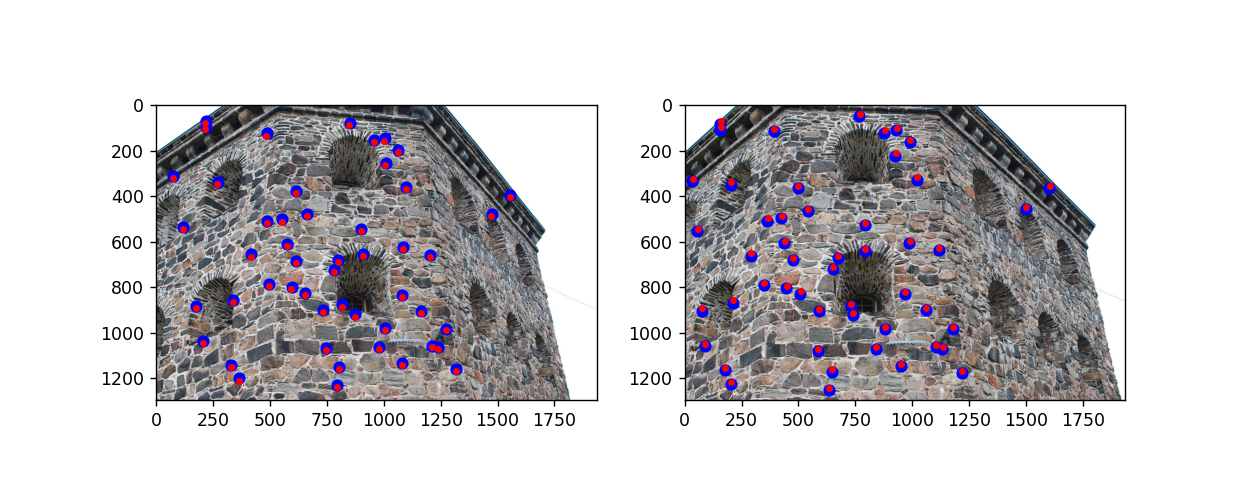

In [15]:
# Randomly select N=50 matches (pairs of features in two images) from the set of inliers for E
N = 50
ind_sample2 = np.random.choice(num_inliers, N, replace = False)

# Indicate (E) inlier matches in image 1 and image 2
plt.figure(11,figsize = (10, 4))
ax11_1 = plt.subplot(121)
plt.imshow(imL)
plt.plot(ptsL[ind[E_inliers][ind_sample2], 0], ptsL[ind[E_inliers][ind_sample2], 1], 'ob')
ax11_2 = plt.subplot(122)
plt.imshow(imR)
plt.plot(ptsR[ind[E_inliers][ind_sample2], 0], ptsR[ind[E_inliers][ind_sample2], 1], 'ob')

# project reconstructed 3D points onto both images and display them in red color
# convert correct points (Xa, Xb, Xc, or Xd) to homogeneous 4 vectors
hom_3d = np.hstack((Xc, np.ones((Xc.shape[0],1))))
hom_3d = [np.reshape(X, (4,1)) for X in hom_3d[ind_sample2]]

# project homogeneous 3D points (onto uncalibrated cameras) using correct Projection matrices (KPw and, e.g. KPa)
ptsL_proj = np.array([np.matmul(np.matmul(K, Pw), X) for X in hom_3d])
ptsR_proj = np.array([np.matmul(np.matmul(K, Pc), X) for X in hom_3d])

# convert to regular (inhomogeneous) point
for i in range(2):
    ptsL_proj[:,i] = ptsL_proj[:,i] / ptsL_proj[:,2]
    ptsR_proj[:,i] = ptsR_proj[:,i] / ptsR_proj[:,2]

ptsL_proj = np.squeeze(ptsL_proj[:,:-1])
ptsR_proj = np.squeeze(ptsR_proj[:,:-1])

ax11_1.plot(ptsL_proj[:,0], ptsL_proj[:,1], '.r')
ax11_2.plot(ptsR_proj[:,0], ptsR_proj[:,1], '.r')

plt.show()